In [1]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time

## RWI

In [4]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Data\\RWI')
RWI_mandal = gpd.read_file('01-01-2021.geojson')

RWI_mandal['median'] = 0
for i in range(0, len(RWI_mandal)):
    RWI_mandal['median'].iloc[i] = RWI_mandal['zonalstat'].iloc[i]['median']

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


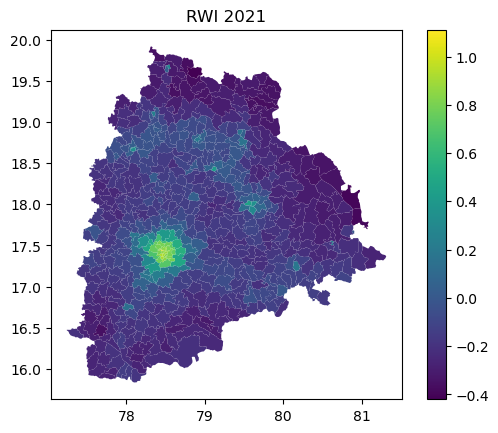

In [7]:
RWI_mandal.plot(column = 'median', legend = True)
plt.title('RWI 2021')
plt.show()

## Population

In [10]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\Data\\Population')
population_mandal = gpd.read_file('01-01-2020.geojson')

population_mandal['mean'] = 0
for i in range(0, len(population_mandal)):
    population_mandal['mean'].iloc[i] = population_mandal['zonalstat'].iloc[i]['mean']

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


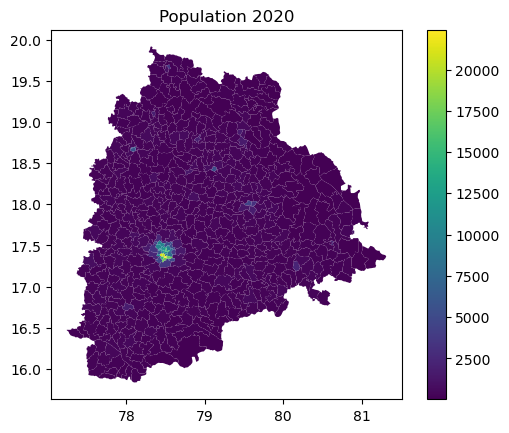

In [15]:
population_mandal.plot(column = 'mean', legend = True)
plt.title('Population 2020')
plt.show()

In [ ]:
#Load Data

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Classification_Fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')
telangana_shape = telangana_shape.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')
district_boundaries = district_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\Mandal_boundaries_pre')
mandal_boundaries = gpd.read_file('mandal_boundaries.shp')
mandal_boundaries = mandal_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse')
one_km_grid = gpd.read_file('telangana_1km_grid.geojson')
one_km_grid = one_km_grid.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse')
ten_km_grid = gpd.read_file('telangana_10km_grid.geojson')
ten_km_grid = ten_km_grid.reset_index()

In [ ]:
def Trend_Score(df, index:int): 
    """Determines the trend score of a polygon it takes as input a dataframe that counts the fires per region per month and the index of a specific region and returns 
    the deviance score of that particular region"""
    df_selected = df[df['index'] == index] 
    df_selected = df_selected.sort_values(by=['ModifiedDateTime'])
    df_selected.index = df_selected['ModifiedDateTime']

    if not df_selected.empty:

        X = df_selected['Fires']

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(df_selected['Fires'], seasonal=7)
        res = stl.fit()

        df_trend = res.trend.to_frame().reset_index().dropna()

        #Date needs to be converted to a numerical value
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        #Set the data in the right format for Linear Regression
        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)

        #Perform Linear Regression and obtain the slope
        reg = LinearRegression().fit(X, y)
        y_pred_trend = reg.predict(X)
        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
        line_slope = slope[0]

    else:
        #If the dataframe is empty there are no fires in that region at all, also no slope line. We are not interested in these regions.
        line_slope = 'Unknown'

    return(line_slope)

In [ ]:
def fire_counts(beginyear:int, endyear:int, fire_data, boundaries, level:str):
    """Creates a visualization of all the slope scores for each region. It takes as input the begin- and endyear of interest, the fire data, the boundaries of the regions we are interested in. """
    st = time.time()

    #Create geodataframe from the data
    geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

    #Make sure the geometry columns are in the right format
    geo_fire_data = geo_fire_data[['geometry', 'acq_date', 'fireID']]
    geo_fire_data['geometry'] = geo_fire_data['geometry'].to_crs(epsg = 4326)
    boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'}) 

    #Load date into date format
    geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
    geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
    geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
    geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

    #Selects the years we are interested in, depending on the input of the function
    geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= str(beginyear)+'-01-01') & (geo_fire_data['acq_date'] < str(endyear+1)+'-01-01')]

    #Count all fires within a region given by the boundaries dataframe
    fires_per_boundaries= gpd.sjoin(geo_fire_data, boundaries, how="inner")

    #Create the right time format: We count per month
    fires_per_boundaries['day'] = 1 
    fires_per_boundaries['year'] = pd.Series(pd.to_numeric(fires_per_boundaries['year'], errors='coerce'), dtype='int64')
    fires_per_boundaries['month'] = pd.Series(pd.to_numeric(fires_per_boundaries['month'], errors='coerce'), dtype='int64')
    fires_per_boundaries['ModifiedDateTime'] = pd.to_datetime(fires_per_boundaries[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

    #Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
    fires_per_boundaries_count = fires_per_boundaries.groupby(['index', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()
    fires_per_boundaries_count['Fires'] = fires_per_boundaries_count[0] 

    #Delete column
    del fires_per_boundaries_count[0]
    
    #Make sure date is in the right format
    fires_per_boundaries_count['ModifiedDateTime'] =  pd.to_datetime(fires_per_boundaries_count['ModifiedDateTime'])

    #We will loop over all boundaries and calculate it's deviant score
    ids= []
    scores = []

    for i in range(0, len(boundaries['index'])):
        ids.append(boundaries['index'].iloc[i])
        #We use the previously defined function in order to calculate the trend score per specific area
        score = Trend_Score(fires_per_boundaries_count, i)
        scores.append(score)
    
    #Create a Dataframe from the scores
    DPPD_df = pd.DataFrame({'index': ids, 'Slope Score': scores}) 

    #Only select the regions that do not have unknown scores
    DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']

    #We merge the dataframe with the boundaries dataframe such that we have the geometry variable
    DPPD_df = DPPD_df.merge(boundaries[['index', 'geometry']], how='left', on=['index'])

    #Making sure data has the right type
    DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
    DPPD_df['Slope Score'] = DPPD_df['Slope Score'].astype('float')

    #Define text for the plots
    text = 'Changes in Amount of Fires over the Years STL ' + level + ' level ('+ str(beginyear) +'-'+str(endyear)+')'
   
    #Create the figure
    #If the boundary level is Telangana we need to select our own min and max legend value 
    if level == 'telangana':
        #Make sure that legend is centered around 0
        norm = TwoSlopeNorm(vmin= -0.07 , vcenter=0, vmax= 0.07) 
        cmap = 'RdYlGn_r'
        DPPD_df.plot(column = 'Slope Score', 
                            legend = True, 
                            figsize = [20,10],\
                            legend_kwds = {'label': 'Deviance'}, 
                            cmap = 'RdYlGn_r',
                            norm = norm)
        plt.title(text)
        os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\results')
        plt.savefig(text + '.png')

    #Create the figure 
    else:
        vmin, vmax, vcenter = DPPD_df['Slope Score'].min(), DPPD_df['Slope Score'].max(), 0
        norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) 
        # create a normalized colorbar
        cmap = 'RdYlGn_r'
        cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        DPPD_df.plot(column = 'Slope Score', 
                            legend = True, 
                            figsize = [20,10],\
                            legend_kwds = {'label': 'Deviance'}, 
                            cmap = 'RdYlGn_r',
                            norm = norm)
        plt.title(text)
        plt.savefig(text + '.png')
    
    #Print the time it took to run this is no more than 15 min no matter the boundary type
    print('Scores are calculated in',  str((time.time()-st)/60) , ' minutes')
    
    return(plt.show())
